In [ ]:
import tensorflow as tf
from keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
import numpy as np
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt

## Завантажуємо датасет

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Робимо функцію для перетворення масивів зображень у формат png

In [ ]:
def save_images(data, labels, folder_name):
    # Створення директорії для збереження
    os.makedirs(folder_name, exist_ok=True)
    unique_labels = np.unique(labels)

    # Створення підпапок для кожного класу
    for label in unique_labels:
        os.makedirs(os.path.join(folder_name, str(label)), exist_ok=True)

    # Збереження зображень
    for idx, (image, label) in enumerate(zip(data, labels)):
        image = Image.fromarray(image)  # Перетворення у формат зображення
        image.save(os.path.join(folder_name, str(label), f"{idx}.png"))

## Перетворюємо масиви в картинки

In [ ]:
save_images(x_train, y_train, "fashion_mnist_train")
save_images(x_test, y_test, "fashion_mnist_test")

## Функція для створення датасету з меншою вибіркою

In [ ]:
def create_subset(source_dir, dest_dir, num_train=100, num_test=50):
    """
    Створює підкаталоги в новій папці, копіюючи обмежену кількість зображень.
    source_dir: шлях до вихідної папки (fashion_mnist_train чи fashion_mnist_test).
    dest_dir: шлях до папки, де будуть збережені нові обмежені дані.
    num_train: кількість зображень для тренувального набору.
    num_test: кількість зображень для тестового набору.
    """
    # Перевірка, чи існує папка призначення, і створення її, якщо не існує
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Отримуємо список класів (підкаталогів)
    class_names = os.listdir(source_dir)

    for class_name in class_names:
        class_folder = os.path.join(source_dir, class_name)
        if os.path.isdir(class_folder):
            # Створення папки для цього класу в новій директорії
            dest_class_folder = os.path.join(dest_dir, class_name)
            if not os.path.exists(dest_class_folder):
                os.makedirs(dest_class_folder)

            # Отримуємо список файлів зображень у цьому класі
            image_files = [f for f in os.listdir(class_folder) if f.endswith('.png')]
            image_files.sort()  # Сортуємо, щоб брати перші зображення

            # Копіюємо перші 'num_train' файлів для тренувального набору
            if 'train' in dest_dir:
                for i, image_file in enumerate(image_files[:num_train]):
                    src_image = os.path.join(class_folder, image_file)
                    dest_image = os.path.join(dest_class_folder, image_file)
                    shutil.copy(src_image, dest_image)

            # Якщо ми працюємо з тестовим набором, копіюємо перші 'num_test' файлів
            if 'test' in dest_dir:
                for i, image_file in enumerate(image_files[:num_test]):
                    src_image = os.path.join(class_folder, image_file)
                    dest_image = os.path.join(dest_class_folder, image_file)
                    shutil.copy(src_image, dest_image)

In [ ]:
# !rm -rf fashion_mnist_train_subset
# !rm -rf fashion_mnist_test_subset

## Зменшуємо датасет на 2000 тренувальних картинок та 1000 тестових

In [ ]:
# Створення підкаталогів для обмежених тренувальних даних (перші 100 зображень з кожного класу)
create_subset('fashion_mnist_train', 'fashion_mnist_train_subset', num_train=200)

# Створення підкаталогів для обмежених тестових даних (перші 50 зображень з кожного класу)
create_subset('fashion_mnist_test', 'fashion_mnist_test_subset', num_test=100)

## Підготуємо картинки до навчання (нормалізуємо канал, поділивши його на 255).

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = datagen.flow_from_directory("fashion_mnist_train",
                                         target_size=(28, 28),
                                         color_mode='grayscale',
                                         class_mode='categorical',
                                         batch_size=32)

test_data = datagen.flow_from_directory("fashion_mnist_test",
                                        target_size=(28, 28),
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        batch_size=32)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


## Перевірка кроків на епоху

In [ ]:
steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 1875
Validation steps: 312


## Створюємо екземпляр моделі

In [ ]:
model1 = Sequential([
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2), padding="same",),

    Conv2D(64, (3, 3), padding="same", activation="relu"),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2), padding="same",),

    Flatten(),

    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Компіляція моделі

In [ ]:
model1.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["acc"]
)

## Навчання моделі на 10 епохах з розміром батчів 32 за замовчуванням

In [ ]:
history1 = model1.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - acc: 0.7421 - loss: 0.7038 - val_acc: 0.8726 - val_loss: 0.3368
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - acc: 0.8797 - loss: 0.3351 - val_acc: 0.9035 - val_loss: 0.2598
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - acc: 0.9014 - loss: 0.2777 - val_acc: 0.9017 - val_loss: 0.2657
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - acc: 0.9139 - loss: 0.2396 - val_acc: 0.9124 - val_loss: 0.2370
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - acc: 0.9210 - loss: 0.2153 - val_acc: 0.9178 - val_loss: 0.2298
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - acc: 0.9279 - loss: 0.1984 - val_acc: 0.9174 - val_loss: 0.2362
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - acc: 0.9347 - loss: 0.1780 - val_acc: 0.9247 - val_loss: 0.2132
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - acc: 0.9400 - loss: 0.1640 - val_acc: 0.9257 - val_loss: 0.2216
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━

## Побудуємо графік втрат та точності тренувальних та тестових даних

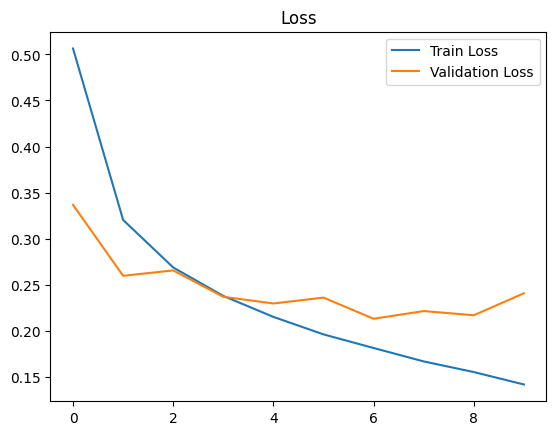

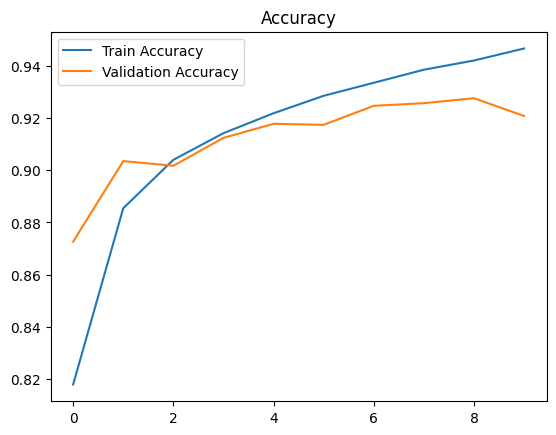

In [ ]:
# Графік втрат
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Графік точності
plt.plot(history1.history['acc'], label='Train Accuracy')
plt.plot(history1.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

## На графіку ми бачимо, що точність на тренувальних даних досягла 95%, а на тестових - 93%. Це дуже гарний результат для моделі, яку ми створили власноруч.

## Перевіримо остаточну точність моделі на тестових даних

In [ ]:
test_loss, test_accuracy = model1.evaluate(test_data, steps=validation_steps)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.9223 - loss: 0.2470
Test Loss: 0.2400
Test Accuracy: 0.9210


## Похибка великувата (0.23), проте точність 93%, як зазначено раніше.
## У порівнянні з попередньою моделлю, яку ми робили на минулому занятті, де було створено багатошарову глибоку нейромережу без використання фільтрів, тут ми отримали набагато кращий результат точності: 93%, ніж 90% у минулої моделі.

## Тепер перейдемо до другого завдання. Спробуємо донавчити модель VGG16. Спочатку нормалізуємо дані з меншої вибірки, яку ми створювали раніше. Обмеження кількості даних пов'язано з тим, що ця модель заскладна і її потрібно ресайзити у більші розміри (224, 224) та додавати 3 канали, замість одного, а навчання з такими даними занадто витратне, тому ми маємо зменшити вибірку. Пізніше ми дізнаємось як це вплине на навчання.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'fashion_mnist_train_subset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    'fashion_mnist_test_subset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


## Створюємо модель та компілюємо її, проте тут ми маємо заморозити усі шари моделі VGG16 і створити власні повнозв'язані, які спочатку маємо навчити. Також оптимізатор має бути з швидкістю навчання меншою, ніж зазвичай, щоб не сталося перенавчання.

In [ ]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = False

model2 = Sequential([
   conv_base,
   Flatten(),
   Dense(128, activation="relu"),
   Dropout(0.5),
   Dense(10, activation="softmax"),
])

model2.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["acc"]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Можемо подивитися на структуру моделі і кількість тренувальних та нетренувальних параметрів (параметрів, які будуть змінювати ваги або навпаки)

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,927,370 (68.39 MB)

 Trainable params: 3,212,682 (12.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Навчаємо модель на 20 епохах

In [ ]:
history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 442ms/step - acc: 0.3677 - loss: 1.8347 - val_acc: 0.8100 - val_loss: 0.7378
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - acc: 0.7312 - loss: 0.8624 - val_acc: 0.8180 - val_loss: 0.5924
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - acc: 0.7871 - loss: 0.6838 - val_acc: 0.8370 - val_loss: 0.5077
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - acc: 0.8077 - loss: 0.5859 - val_acc: 0.8530 - val_loss: 0.4541
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - acc: 0.8133 - loss: 0.5543 - val_acc: 0.8610 - val_loss: 0.4150
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - acc: 0.8649 - loss: 0.4490 - val_acc: 0.8700 - val_loss: 0.3956
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - acc: 0.8625 - loss: 0.4403 - val_acc: 0.8640 - val_loss: 0.3996
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - acc: 0.8480 - loss: 0.4550 - val_acc: 0.8800 - val_loss: 0.3664
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/

## У результаті навчання, остаточна модель показує точність на тренувальних даних 93%, а на валідаційних - 88%.

## Тепер перейдемо до донавчання. Розморозимо останні слої моделі VGG16, починаючи з 5 блоку, щоб вони могли донавчитися

In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

## Компілюємо модель, тільки тепер зменшуємо швидкість навчання ще більше, для того, щоб не пошкодити уявлення базової моделі

In [ ]:
model2.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.00001),
    metrics=["acc"]
)

## Донавчаємо всю модель на 20 епохах

In [ ]:
history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 278ms/step - acc: 0.9493 - loss: 0.1713 - val_acc: 0.8920 - val_loss: 0.3318
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 221ms/step - acc: 0.9610 - loss: 0.1278 - val_acc: 0.8870 - val_loss: 0.3357
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - acc: 0.9576 - loss: 0.1367 - val_acc: 0.9020 - val_loss: 0.3112
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - acc: 0.9676 - loss: 0.1170 - val_acc: 0.8960 - val_loss: 0.3272
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - acc: 0.9722 - loss: 0.1012 - val_acc: 0.9020 - val_loss: 0.3164
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - acc: 0.9742 - loss: 0.0899 - val_acc: 0.8890 - val_loss: 0.3369
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - acc: 0.9848 - loss: 0.0759 - val_acc: 0.9020 - val_loss: 0.3328
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 240ms/step - acc: 0.9834 - loss: 0.0717 - val_acc: 0.8950 - val_loss: 0.3617
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/

## Візуалізуємо історію точності та похибки

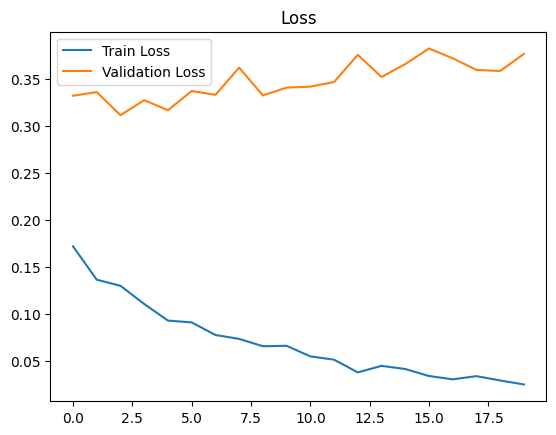

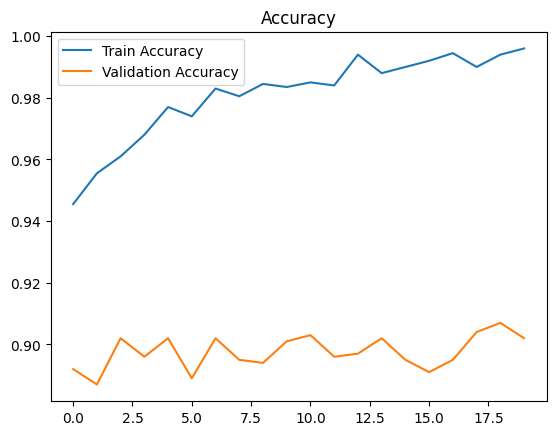

In [ ]:
# Графік втрат
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Графік точності
plt.plot(history2.history['acc'], label='Train Accuracy')
plt.plot(history2.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

## На графіку видно, що модель на тренувальних даних значно покращилась, а от на тестових взагалі нічого не змінилося, а похибка тільки виросла.

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,511,584 (146.91 MB)

 Trainable params: 10,292,106 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 20,584,214 (78.52 MB)

## Перевіряємо якість навчання на тестових даних

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = test_generator.samples // test_generator.batch_size
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 62
Validation steps: 31


In [ ]:
test_loss, test_accuracy = model2.evaluate(test_generator, steps=validation_steps)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - acc: 0.9038 - loss: 0.3180
Test Loss: 0.3507
Test Accuracy: 0.9052


## Висновок:
## Результат точності на тестових даних всього 90% - це значно менше, ніж у першої моделі, створеної власноруч, у якої точність була 93%. Це, скоріше за все, пов'язано з тим, що в нас замала вибірка для тренування і вона не змогла навчитися узагальнювати свої передбачення, а тільки перенавчилася на тренувальних даних. Можливо, якби ми навчали її на цілому датасеті, точність була б набагато кращою, але навчання зайняло б також набагато більше часу.

## Тепер збережемо наші моделі

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model1.save('fashion_mnist_model1.h5')

In [ ]:
model2.save('fashion_mnist_vgg16_model.h5')

In [ ]:
!cp fashion_mnist_model1.h5 /content/drive/MyDrive/data_science/Hw13

In [ ]:
!cp fashion_mnist_model1.h5 /content/drive/MyDrive/data_science/Hw13